In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

## Models

In [2]:
## phi = sin(x)sin(y)
## 5 or more with relu
## More layers for resnet
## make sure to introduce dropout lyers fro generalization and make sure to initialize the weights correctly
## xaviar distribution for initialization or gaussian.
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        # m.bias.data.fill_(0.01)

class Res(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Res, self).__init__()
        ## Layer initialization
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout1 = nn.Dropout(0.5)

        ## weight initialization
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)


    def forward(self, x):
        x1 = torch.tanh(self.fc1(x))
        x2 = torch.tanh(self.dropout1(self.fc2(x1)))
        x3 = self.fc3(x2 + x1)
        return x3

class SimplestNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimplestNeuralNetwork, self).__init__()
        ## Layer initialization
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

        ## weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        x1 = nn.functional.relu(self.fc1(x))
        x5 = self.fc5(x1)
        return x5

class SimpleReluNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleReluNet, self).__init__()
        ## Layer initialization
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.25)

        ## weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        x1 = nn.functional.relu(self.fc1(x))
        x2 = nn.functional.relu(self.dropout1(self.fc2(x1)))
        x3 = nn.functional.relu(self.fc3(x2))
        x4 = nn.functional.relu(self.dropout2(self.fc4(x3)))
        x5 = self.fc5(x4)
        return x5

class GeneralReLuNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(GeneralReLuNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                if torch.rand() < 0.1:
                    print(f"Dropout at layer {i}")
                    layers.append(nn.Dropout(0.25 + torch.rand()/4))
                layers.append(nn.ReLu())
        self.network = nn.Sequential(*layers)
        self.network.apply(init_weights)

    def forward(self, x):
        return self.network(x)

In [7]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [45]:
from einops import rearrange, repeat
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels * out_channels))
        # self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        # weight is stored as real to avoid issue with Adam not working on complex parameters
        # FNO code initializes with rand but we initializes with randn as that seems more natural.
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, self.modes1, 2))
        # Need unsafe=True since we're changing the dtype of the parameters
        # parametrize.register_parametrization(self, 'weights1', RealToComplex(), unsafe=True)

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x, norm='ortho')

        # Multiply relevant Fourier modes
        # out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        # out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)
        weights1 = torch.view_as_complex(self.weights1)
        out_ft = F.pad(self.compl_mul1d(x_ft[:, :, :self.modes1], weights1),
                       (0, x_ft.shape[-1] - self.modes1))

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1), norm='ortho')
        return x

class FourierOperator1d(nn.Module):

    def __init__(self, modes, width):
        super().__init__()
        self.modes = modes
        self.width = width
        self.conv = SpectralConv1d(self.width, self.width, self.modes)
        self.w = nn.Conv1d(self.width, self.width, 1)

    def forward(self, x):
        return F.gelu(self.conv(x) + self.w(x))


class FNO1d(nn.Module):
    def __init__(self, modes, width = 128, nlayers=4, padding=0):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.nlayers = nlayers
        self.padding = padding  # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width)  # input channel is 2: (a(x), x)

        self.layers = nn.Sequential(*[FourierOperator1d(self.modes1, self.width)
                                      for _ in range(self.nlayers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # if len(x.shape) == 1:
        #     x = x.reshape(1, -1)
        grid = self.get_grid(x.shape, x.device)
        x = torch.stack([x, grid], dim=-1)
        x = self.fc0(x)
        x = rearrange(x, 'b x c -> b c x')
        if self.padding != 0:
            x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        # FNO code doesn't apply activation on the last block, but we do for code's simplicity.
        # Performance seems about the same.
        x = self.layers(x)

        if self.padding != 0:
            x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = rearrange(x, 'b c x -> b x c')
        x = self.fc2(F.gelu(self.fc1(x)))
        return rearrange(x, 'b x 1 -> b x')

    def get_grid(self, shape, device):
        if len(shape) == 1:
            batchsize, size_x = 1, shape[0]
        else:
            batchsize, size_x = shape[0], shape[1]
        return repeat(torch.linspace(0, 1, size_x, dtype=torch.float, device=device),
                      'x -> b x', b=batchsize)


## sin_prod

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class PDEDataset(Dataset):
    def __init__(self, x_gr):
        self.x = x_gr
        self.y = pde_rhs(self.x)  # Assign the entire tensor at once
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def create_dataset(x_gr):
    dataset = PDEDataset(x_gr)
    return dataset

def phi(x : torch.tensor) -> torch.tensor:
    return torch.prod(torch.sin(x), dim = 0)

def q(x : torch.tensor) -> torch.tensor:
    return torch.ones(x.shape, device = device)

def p(x : torch.tensor) -> torch.tensor:
    sum_cos = torch.cos(torch.sum(x, dim = 1)).to(device)
    sinx = torch.sin(x)
    cosx = torch.cos(x)
    t = torch.stack((cosx[:, 0]*sinx[:, 1], sinx[:, 0]*cosx[:, 1]), dim = 1).to(device)
    return sum_cos.reshape(-1, 1) + 1 - 2*t

def plot_contour(func, title = "Contour plot for phi(x) = sin(x)sin(y)"):
    x = torch.linspace(0, 2*torch.pi, 100)
    X, Y = torch.meshgrid(x, x)
    Z = torch.empty_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(torch.tensor([X[i, j], Y[i, j]]))
    plt.contourf(X, Y, Z)
    plt.colorbar()
    plt.title(title)
    plt.show()


def pde_rhs(x):
    with torch.no_grad():
        rhs = p(x) - q(x)
    return rhs

# plot_contour(phi)

num_samples = 2500
dim = 2
x_max = 2*torch.pi
x_min = 0
x_gr = torch.rand(num_samples, 2) * (abs(x_max) + abs(x_min)) + x_min
dataset = create_dataset(x_gr)
# torch.save(dataset, f"dataset_sin_{num_samples}.pth")


In [ ]:
dataset

## training loop

In [42]:
# fc + residual block
def pde(tar_sc , model, x):
    x= x.requires_grad_(True)  # Create a separate variable for use in this function
    dy = lambda p : torch.func.jacrev(model)(p).squeeze()
    dy_dotq = lambda x : torch.dot(dy(x), tar_sc(x))
    d_dy_dotq = torch.func.jacrev(dy_dotq)
    divergence_dy = lambda x : torch.trace(torch.func.jacrev(dy)(x))
    d_divergence_dy = torch.func.jacrev(divergence_dy)
    pde_lhs = d_divergence_dy(x) + d_dy_dotq(x)
    return pde_lhs

## remains to fix
def train_pde(model, tar_sc, dataloader, optimizer, batchsize, device, epochs=10, fno = False):
    loss_list = []
    print("Training the model...")
    output = torch.empty((batchsize, 2), device = device)
    for epoch in tqdm(range(epochs)):
        # optimizer.zero_grad()
        for t, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            x_g = x.to(device)
            y_g = y.to(device)
            new_output = torch.empty_like(output)
            for i, x_i in enumerate(x_g):
                x_out = x_i.detach().clone()
                # if fno :
                #     x_out = x_out.reshape(1, -1)
                new_output[i] = pde(tar_sc, model, x_out)
            output = new_output
            pde_loss = nn.functional.mse_loss(output, y_g.float())
            # loss = pde_loss
            pde_loss.backward()
            optimizer.step()
        print("loss:", pde_loss.item())
        loss_list.append(pde_loss.item())
    return loss_list

def solve_newton_step_pinn(tar_sc, lr, batchsize, device, num_train, num_test, model_type, epochs=25):
    if model_type == "res":
        model = Res(input_dim=2, hidden_dim=50, output_dim=1)
    elif model_type == "general":
        model = GeneralReLuNet(input_size = 2, hidden_sizes = [50, 50, 64, 25], output_size = 1)
    elif model_type == "FNO":
        model = FNO1d(1)
    else:
        model = SimpleReluNet(2, 50, 1)
    model = model.to(device)
    x_max = 2*torch.pi
    x_min = 0
    ## train
    x_gr = torch.rand(num_train, 2) * (abs(x_max) + abs(x_min)) + x_min
    train_dataset = create_dataset(x_gr)
    train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_lst = train_pde(model, tar_sc, train_dataloader, optimizer, batchsize, device, epochs, fno = (model_type == 'FNO'))
    return model, loss_lst

## tbd
def test_model(model, num_test):
    ## test
    x_gr = torch.rand(num_test, 2) * (abs(x_max) + abs(x_min)) + x_min
    test_dataset = create_dataset(x_gr)
    model.eval()
    with torch.no_grad():
        model_predictions = model(x_gr).cpu().numpy().flatten()

In [40]:
model, loss = solve_newton_step_pinn(q, 0.01, 100, "cuda", 2000, 1000, "FNO", epochs = 15)

Training the model...


  0%|          | 0/15 [00:00<?, ?it/s]

tensor([3.0488, 0.1666], device='cuda:0', requires_grad=True)


RuntimeError: expected a matrix

In [43]:
model, loss = solve_newton_step_pinn(q, 0.01, 100, "cuda", 2000, 1000, "", epochs = 15)

Training the model...


  7%|▋         | 1/15 [00:31<07:21, 31.51s/it]

loss: 1.4265942573547363


 13%|█▎        | 2/15 [01:02<06:49, 31.48s/it]

loss: 1.610350251197815


 20%|██        | 3/15 [01:34<06:17, 31.48s/it]

loss: 1.393060326576233


 27%|██▋       | 4/15 [02:05<05:45, 31.44s/it]

loss: 1.535891056060791


 33%|███▎      | 5/15 [02:37<05:13, 31.36s/it]

loss: 1.5547106266021729


 40%|████      | 6/15 [03:08<04:42, 31.43s/it]

loss: 1.5501890182495117


 47%|████▋     | 7/15 [03:40<04:12, 31.56s/it]

loss: 1.461422085762024


 53%|█████▎    | 8/15 [04:12<03:41, 31.61s/it]

loss: 1.613027572631836


 60%|██████    | 9/15 [04:43<03:08, 31.48s/it]

loss: 1.4814834594726562


 67%|██████▋   | 10/15 [05:14<02:37, 31.45s/it]

loss: 1.4722546339035034


 73%|███████▎  | 11/15 [05:45<02:05, 31.35s/it]

loss: 1.4382396936416626


 80%|████████  | 12/15 [06:17<01:33, 31.33s/it]

loss: 1.5949081182479858


 87%|████████▋ | 13/15 [06:48<01:02, 31.32s/it]

loss: 1.676755666732788


 93%|█████████▎| 14/15 [07:19<00:31, 31.29s/it]

loss: 1.5452685356140137


100%|██████████| 15/15 [07:51<00:00, 31.40s/it]

loss: 1.5257456302642822


In [46]:
model_res, loss_res = solve_newton_step_pinn(q, 0.01, 100, "cuda", 2000, 1000, "res", epochs = 15)

Training the model...


  7%|▋         | 1/15 [00:31<07:22, 31.61s/it]

loss: 0.7239764332771301


 13%|█▎        | 2/15 [01:02<06:48, 31.43s/it]

loss: 0.5210601687431335


 20%|██        | 3/15 [01:34<06:16, 31.39s/it]

loss: 0.24588315188884735


 27%|██▋       | 4/15 [02:05<05:44, 31.36s/it]

loss: 0.30437320470809937


 33%|███▎      | 5/15 [02:36<05:13, 31.31s/it]

loss: 0.27284345030784607


 40%|████      | 6/15 [03:08<04:42, 31.38s/it]

loss: 0.30089589953422546


 47%|████▋     | 7/15 [03:40<04:11, 31.48s/it]

loss: 0.22628989815711975


 53%|█████▎    | 8/15 [04:11<03:40, 31.50s/it]

loss: 0.28271740674972534


 60%|██████    | 9/15 [04:42<03:08, 31.44s/it]

loss: 0.12077342718839645


 67%|██████▋   | 10/15 [05:14<02:37, 31.43s/it]

loss: 0.18174241483211517


 73%|███████▎  | 11/15 [05:45<02:05, 31.41s/it]

loss: 0.24127253890037537


 80%|████████  | 12/15 [06:16<01:34, 31.39s/it]

loss: 0.13454443216323853


 87%|████████▋ | 13/15 [06:48<01:02, 31.39s/it]

loss: 0.18083392083644867


 93%|█████████▎| 14/15 [07:19<00:31, 31.42s/it]

loss: 0.12331773340702057


100%|██████████| 15/15 [07:51<00:00, 31.42s/it]

loss: 0.14242494106292725


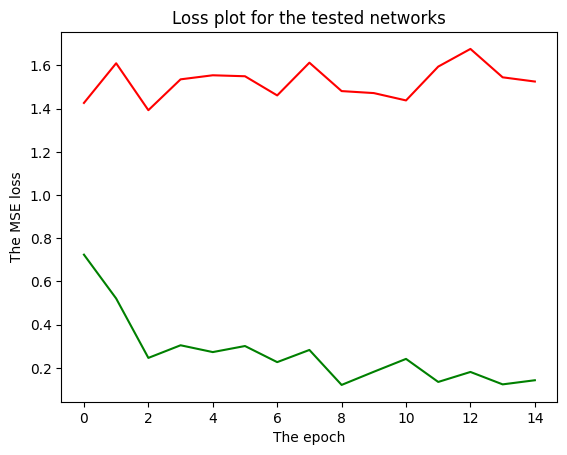

In [47]:
plt.plot(loss, color = 'r', label = "Simple ReLu")
plt.plot(loss_res, color = 'g', label = "res")
plt.title(f"Loss plot for the tested networks")
plt.xlabel("The epoch")
plt.ylabel("The MSE loss")
plt.show()

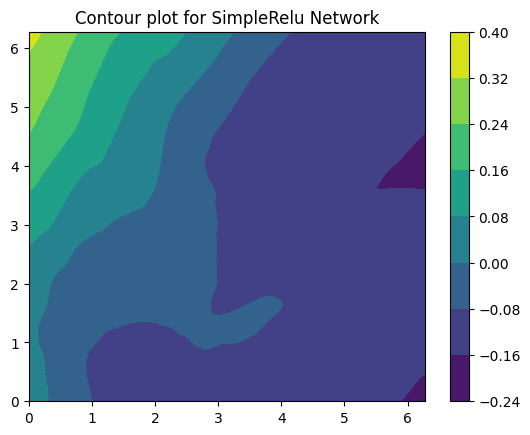

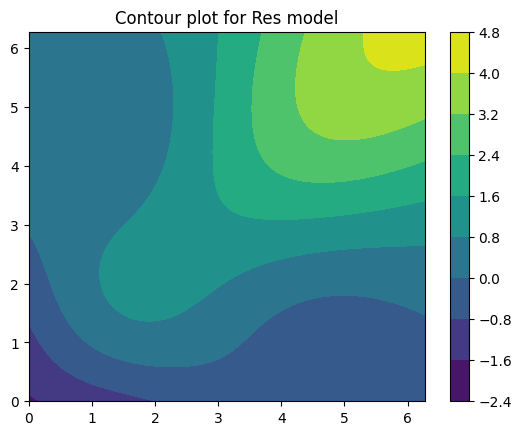

In [48]:
model.to("cpu")
model_res.to("cpu")
model.eval()
model_res.eval()

with torch.no_grad():
    plot_contour(model, "Contour plot for SimpleRelu Network")
    plot_contour(model_res, "Contour plot for Res model")

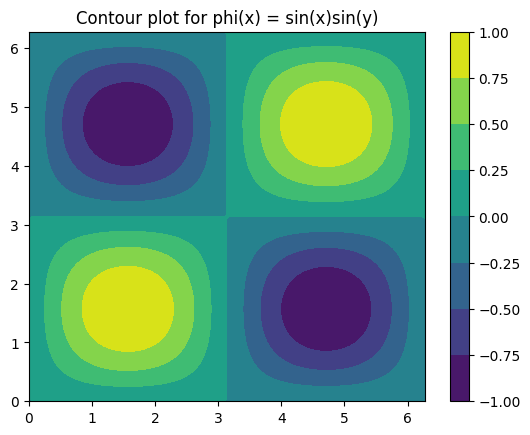

In [49]:
plot_contour(phi)